# Data Preprocessing (Fragility Algo.)

1. Ran fragility analysis on SEEG data - log seizure times using Z
2. Run projection onto 2D/3D tensors, keep track of seizure times

This is done in comparison with the FFT to show in a result that:
- fragility > FFT in seizure detection using whole network data
- fragility can be formatted as input into the TVB Transfer Learning Pipeline

In [39]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
import fragility.util.utils as futil
import datainterface.patient as Pat
# from fragility.signalprocessing import frequencyanalysis
# from datainterface import readmat

# sys.path.append('/home/adamli/tng_tvb/')
# from tvbsim import visualize

import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.io

import peakdetect

sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import tvbsim.util

from natsort import natsorted
import ntpath

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

# 1 Load in Data (Either Simulated or Real

In [4]:
expname = 'traindata'
datadir = os.path.join('/Volumes/ADAM LI/pydata/tvbforwardsim/', expname)
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# fragility results dir
resultsdir = os.path.join('/Volumes/ADAM LI/pydata/output/traindata')

# expname = 'allregions_notmoved'
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/')
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)

# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)
    
# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
#     if 'allregions_sim' not in root:
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))
print(len(datafiles))
# print(datafiles[50:])
# print(datafiles)

0


In [ ]:
for idx, datafile in enumerate(datafiles):
    filename = path_leaf(datafile)
    print(filename)
    
    data = np.load(rawdatafile, encoding='bytes')
    metadata = data['metadata'].item()
    zts = data['zts']
    
    print(metadata.keys())
    # Extract location coordinates
    locations = metadata[b'seeg_xyz']
    try:
        patient_id = metadata[b'patient'].decode("utf-8") 
    except:
        patient = '_'.join(filename.split('_')[0:2])
    ezindices = metadata[b'ezindices']
    pzindices = metadata[b'pzindices']
    seeg_contacts = metadata[b'seeg_contacts']

    # get the actual seizure times and offsets
    allindices = np.append(ezindices.ravel(), pzindices.ravel(), axis=0)
    settimes = postprocessor.getonsetsoffsets(zts, 
                allindices, delta=0.2/5)
    seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)
    
    # load results data
    data = np.load(resultfile)
    print(data.keys())
    
    # load time points, fragility
    
    filename = os.path.join(traindir, 
             filename+'_'+str(idx)+'.npz')
    print(filename)
    
    ###################### PERFORM IMAGE MESHING ######################
    print("using pca to grid image")
    new_locs = pca.fit_transform(locations)
    print(seizonsets)
    print(seizoffsets)
    ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
    
    if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
        print("skipping ", datafile)
    else:
        # Tensor of size [samples, freqbands, W, H] containing generated images.
        image_tensor = datahandler.gen_images(new_locs, power, 
                                n_gridpoints=32, normalize=True, augment=False, 
                                pca=False, std_mult=0.1, edgeless=False)
    print(image_tensor.shape)

    # instantiate metadata hash table
    metadata = dict()
    metadata['seeg_contacts'] = seeg_contacts
    metadata['new_locs'] = new_locs
    metadata['ylabels'] = ylabels
    
#     # save image and meta data
#     np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)

    print(datafile)
    print(fragmat.shape)
    print(seizonsets, seizoffsets)
    print('\n\n')
    break

In [37]:
sns.heatmap(fragmat_2d, cmap='jet')
plt.colorbar()
plt.show()

img = Image.fromarray(data, 'RGB')
img.save('test.png')

0.0 255.0


(512, 512)


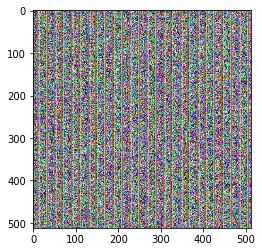

In [38]:
w, h = 512, 512
data = np.random.rand(h, w, 3)
data[256, 256] = [255, 0, 0]
# img = Image.fromarray(data, 'RGB')

# data = np.divide(data, 255.)
print(np.min(data.ravel()), np.max(data.ravel())) 
img = Image.fromarray(data, 'RGB')
img.save('test.png')

img = Image.open('test.png')
print(img.size)
plt.imshow(img)

In [13]:
L = 20      # one side of lattice
N = L*L     # number of sites in the lattice
xs = np.zeros((L, L), float)

for n in range(100):
    for i in range(L):
        for j in range(L):
            xs[i,j] = np.random.uniform(0.1, 0.9)
            plt.imshow(xs)
plt.colorbar()
plt.show()

KeyboardInterrupt: 